In [24]:
import pickle
import pandas as pd
import numpy as np
import os
import torch
import sys
sys.path.append('../')
from cxr_fairness.data import data
from cxr_fairness.data import Constants
import matplotlib.pyplot as plt
from scipy.special import logit, expit
from cxr_fairness.plot_utils import *
from cxr_fairness.data import process
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
import matplotlib.lines as mlines
import matplotlib
from sklearn.metrics import roc_auc_score, recall_score, confusion_matrix
from pathlib import Path
from cxr_fairness.metrics import StandardEvaluator, CalibrationEvaluator

def select_best(d):
    return d.loc[d.worst_roc.idxmax(), 'config_filename']

class smart_dict(dict):
    def __missing__(self, key):
        return key    
grp_name_mapping = smart_dict({
    'F': "Female",
    'M': 'Male',
    0: 'White',
    1: 'Black',
    2: "Other"
})

orders = {
    'sex': ['M', 'F'],
    'ethnicity': [0, 1, 2],
    'age': ['18-40', '40-60', '60-80', '80-']
    
}

In [25]:
configs = pd.read_pickle('/h/haoran/hdd/cxr_debias/selected_configs.pkl').query('task == "No Finding" and dataset == "MIMIC" and select_metric == "worst_roc"')

In [26]:
selected_configs = configs[configs.exp_name == 'erm_baseline']

In [27]:
test_cohort = data.load_df('MIMIC', '0', only_frontal = False)['test']
test_cohort['dicom'] = test_cohort.path.apply(lambda x: x[x.rindex('/')+1:-4])

In [28]:
proxy_labels = pd.read_csv('../aux_data/proxy_labels.csv') # update with path to csv file after running Colab notebook
proxy_labels['subject_id'] = proxy_labels['subject_id'].astype(str)
proxy_labels['study_id'] = proxy_labels['study_id'].astype(str)

In [29]:
before = len(test_cohort)
test_cohort = proxy_labels[['dicom', 'hospital_expire_flag', 'los_all', 'los_after', 'No_Finding']].merge(test_cohort)
test_cohort = test_cohort[(test_cohort['No Finding'] == test_cohort['No_Finding'])] # drop about 600
after = len(test_cohort)
print(before, after)

62701 42877


In [30]:
test_cohort['no_hospital_expire'] = ~test_cohort['hospital_expire_flag'].astype(bool)
test_cohort['los_all_leq_10_days'] = test_cohort['los_all'] <= 24*10
test_cohort['los_after_leq_7_days'] = test_cohort['los_after'] <= 24*7

In [11]:
targets = [
    'No Finding',
    'no_hospital_expire',
    'los_all_leq_10_days',
    'los_after_leq_7_days',
]

plot_mapping = {
    'No Finding': 'No\ Finding',
    'no_hospital_expire': 'No\ Mortality',
    'los_all_leq_10_days': 'LOS_{all} \leq 10d',
    'los_after_leq_7_days': 'LOS_{after} \leq 7d',
}

In [12]:
test_df_raw = []

for i, row in selected_configs.iterrows():  
    p1 = Path('/h/haoran/hdd/cxr_debias/') / row['config_filename'] / 'results.pkl'
    p2 = Path('/h/haoran/cxr_debias/') / row['config_filename'] / 'results.pkl'
    p = p1 if p1.exists() else p2
    pred_df = torch.load(p)['test_pred_df'] 
    
    test_df_i = test_cohort[['path', 'subject_id', 'study_id'] + ['sex', 'ethnicity', 'age'] + targets].merge(pred_df, on = 'path', how = 'inner')
    for r in selected_configs.columns:
        test_df_i[r] = row[r]
    test_df_raw.append(test_df_i)

In [13]:
test_df = pd.concat(test_df_raw)
print(test_df.shape)

(207645, 52)


## Generate Calibration Curves

In [11]:
boot_df = []

for target in targets:
    for attr in ['ethnicity', 'age', 'sex']:
        evaluator = CalibrationEvaluator()
        boot_df_i = evaluator.bootstrap_calibration_curve(test_df, n_boot = 250, 
                                             strata_vars_eval = ['exp_name', 'val_fold', attr],
                                             strata_vars_boot=[attr],
                                             strata_var_replicate="val_fold",
                                             replicate_aggregation_mode=None,
                                             strata_var_experiment="exp_name",
                                             strata_var_group=attr,
                                             baseline_experiment_name=None,
                                             label_var = target,
                                             pred_prob_var = 'pred',
                                             patient_id_var = 'path',
                                             n_jobs = -1,
                                             score_values = np.arange(0.05, 0.96, 0.1),
                                             model_type = 'bin')
        boot_df_i['target'] = target
        boot_df_i['eval_group'] = attr

        boot_df.append(boot_df_i)

In [12]:
boot_df = pd.concat(boot_df)
boot_df.to_pickle('./erm_calibration_proxy_labels.pkl')

## Get Performance Metrics

In [13]:
perf_df = []
thresholds = [0.75, 0.5, 0.25, 0.1]
sens_at_spec = np.arange(0.1, 1., 0.1).tolist()

for target in targets:
    for attr in ['ethnicity', 'age', 'sex']:
        evaluator = StandardEvaluator(thresholds = thresholds,
                                    sens_at_spec = sens_at_spec)

        perf_df_i = evaluator.bootstrap_evaluate(test_df, n_boot = 250,
                                             strata_vars_eval = ["exp_name", "val_fold", attr],
                                             strata_vars_boot=[attr],
                                             strata_var_replicate="val_fold",
                                             replicate_aggregation_mode=None,
                                             strata_var_experiment="exp_name",
                                             strata_var_group=attr,
                                             baseline_experiment_name=None,
                                             compute_overall=True,
                                             compute_group_min_max=False,
                                             label_var = target, 
                                             pred_prob_var = 'pred',
                                            patient_id_var="path",
                                            n_jobs = -1)
        perf_df_i['target'] = target
        perf_df_i['eval_group'] = attr
        perf_df.append(perf_df_i)

In [14]:
perf_df = pd.concat(perf_df)
perf_df.to_pickle('./erm_perf_proxy_labels.pkl')

## Calibration Graphs

In [14]:
boot_df = pd.read_pickle('./erm_calibration_proxy_labels.pkl')
perf_df = pd.read_pickle('./erm_perf_proxy_labels.pkl')

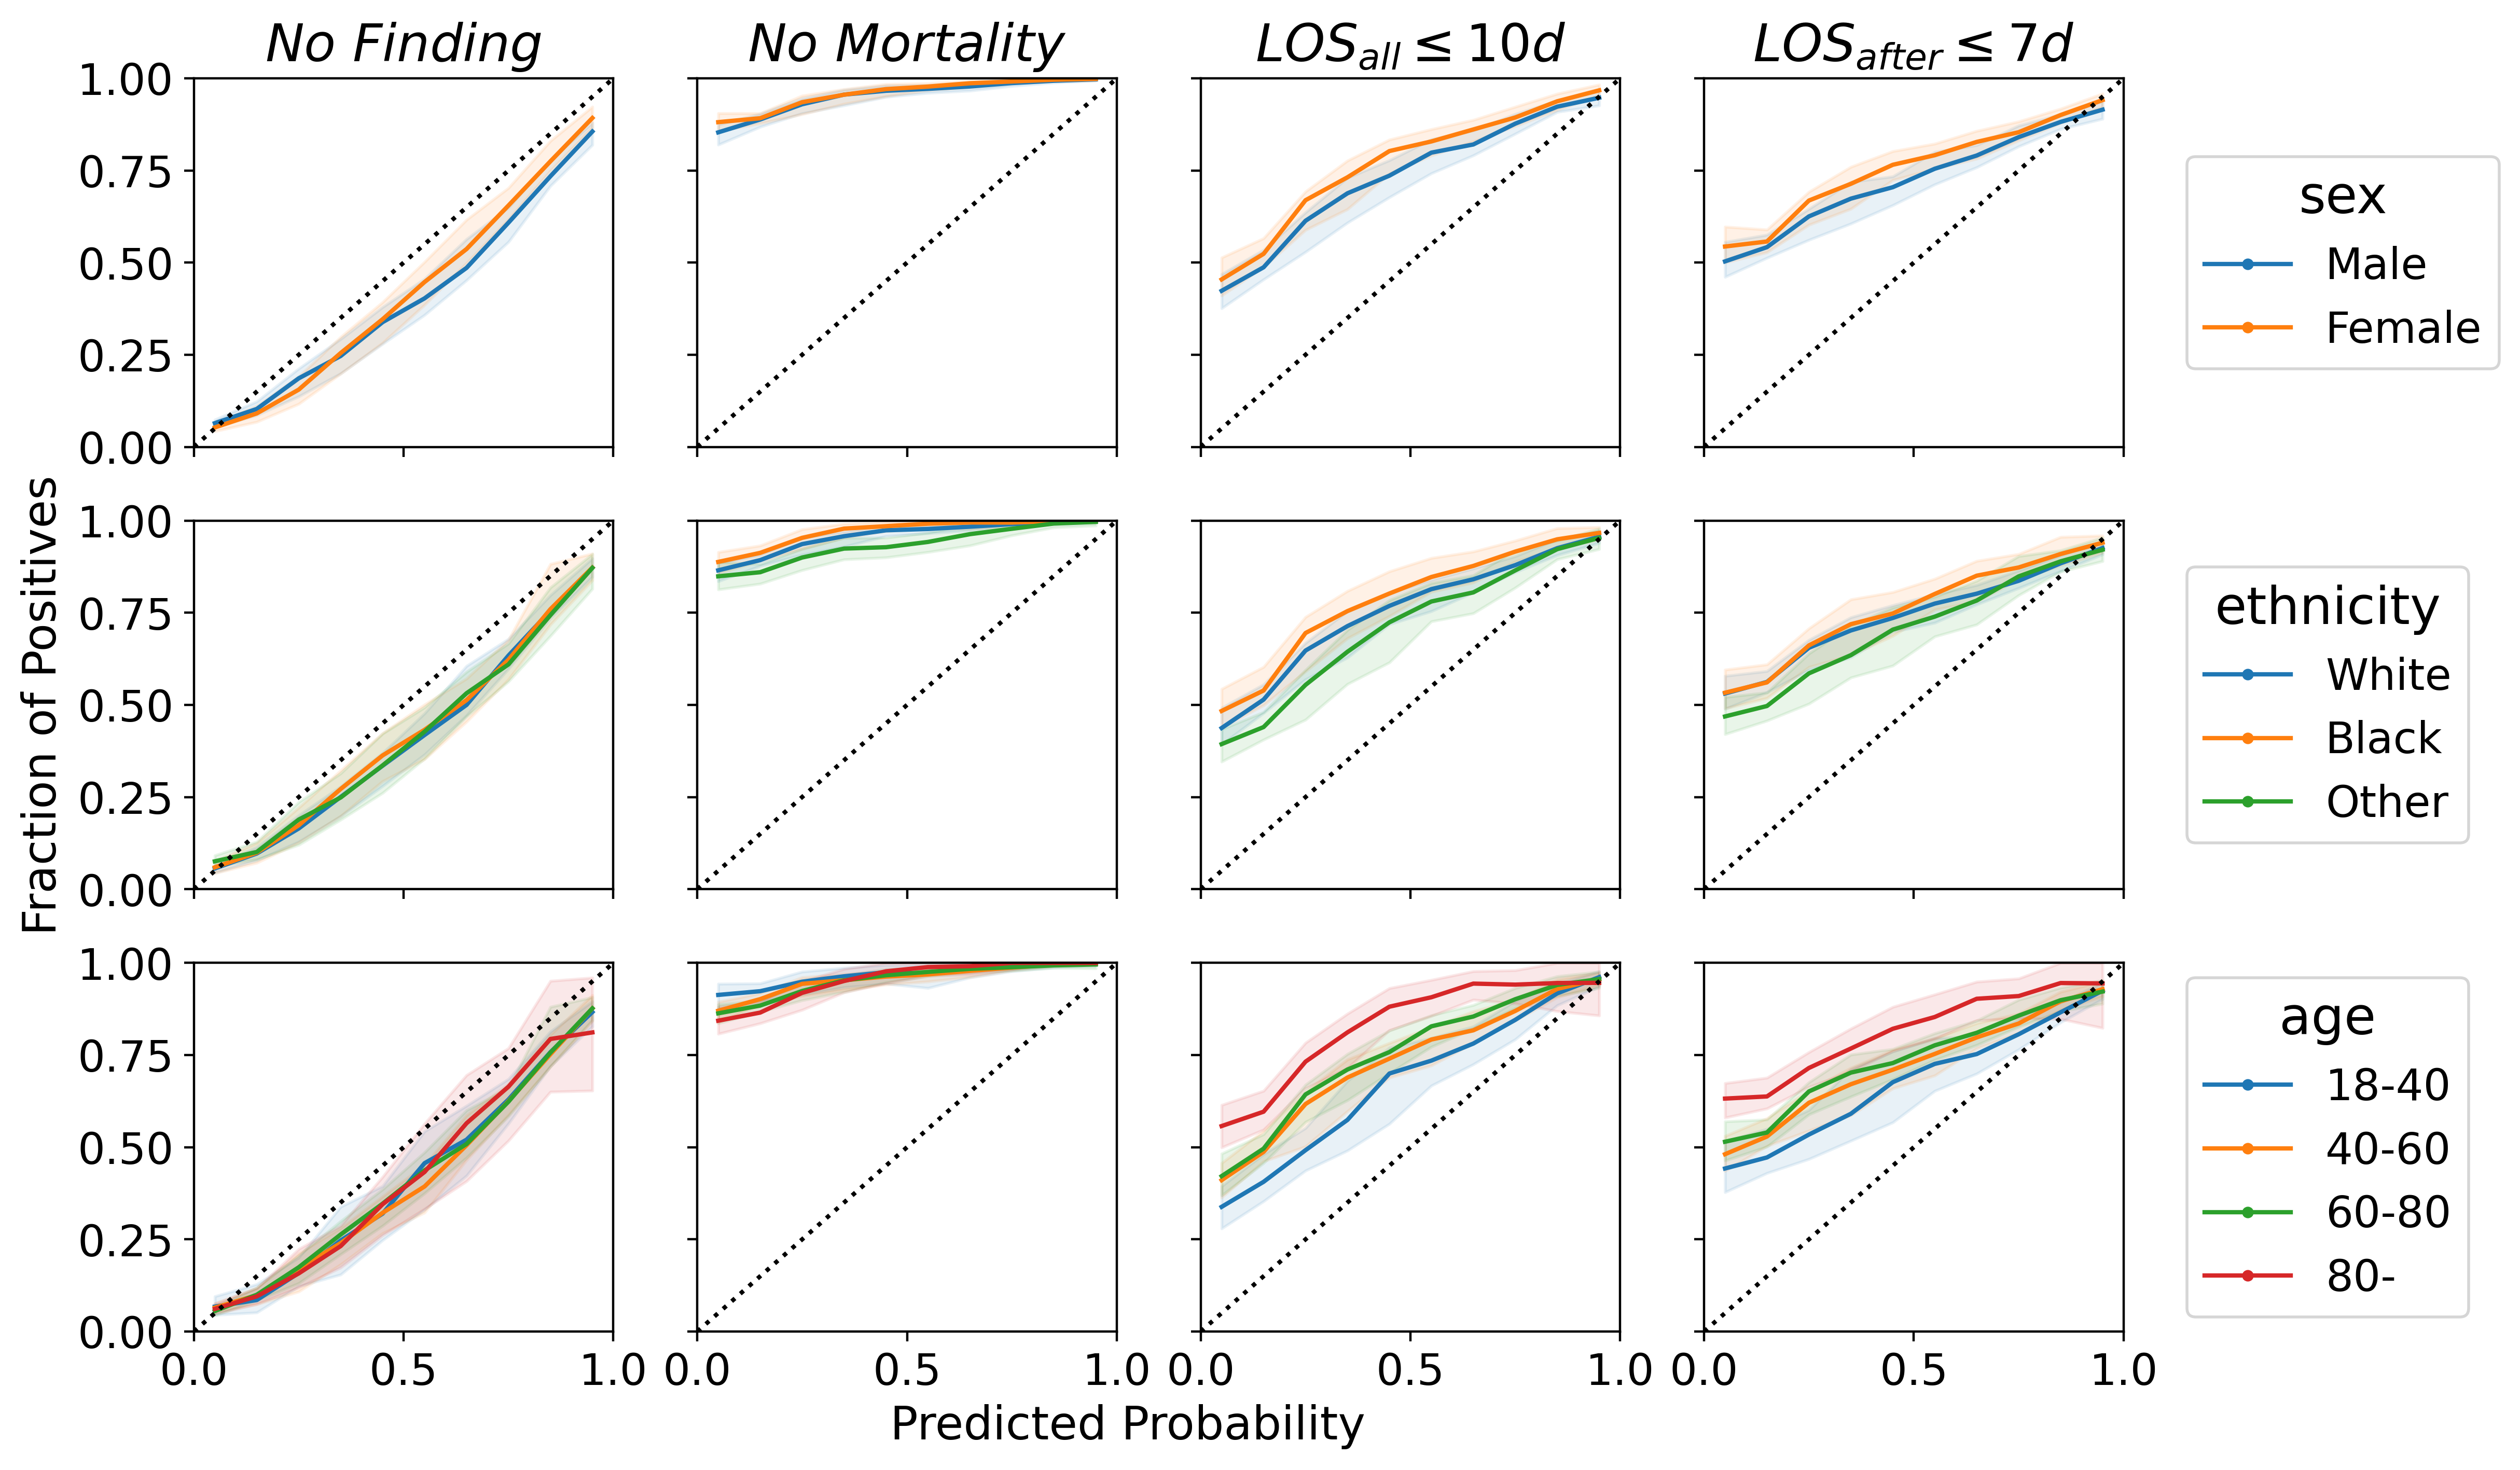

In [15]:
plt.rcParams['font.size'] = '15'
colors = ['C0', 'C1', 'C2', 'C3', 'C4']
fig, axs = plt.subplots(nrows = 3, ncols = len(targets), dpi = 400, figsize = (len(targets)*3,8), sharey = True, sharex = True)
for cc, attr in enumerate(['sex', 'ethnicity', 'age']):    
    if attr == 'sex':
        grps = ['M', 'F']
    else:
        grps = np.sort(boot_df[attr].dropna().unique())
    for c, t in enumerate(targets):
        ax = axs[cc][c]        
        
        for d, grp in enumerate(grps):
            sub = boot_df[(boot_df.target == t) & (boot_df.eval_group == attr) & (boot_df[attr] == grp)].sort_values(by = 'score')
            ax.plot(sub['score'], sub['CI_med'], color = colors[d], label = grp_name_mapping[grp])
            ax.fill_between(sub['score'], sub['CI_lower'], sub['CI_upper'], color = colors[d], alpha = 0.1)        
        ax.set_ylim([0, 1])
        ax.set_xlim([0, 1])                
        ax.plot([0, 1], [0, 1], "k:")
        
#         if cc == 2 and c == 1:
#             ax.set_xlabel("Predicted Probability", fontsize = 16)
            
        if cc == 0:
            ax.set_title('$' + plot_mapping[t] + '$')
    
        if cc == 1 and c == 0:
            ax.set_ylabel('Fraction of Positives', fontsize = 16)
    
    
    legend = [
        mlines.Line2D([], [], linestyle = '-', color = colors[e], marker ='.',
                     label = grp_name_mapping[grp]) for e, grp in enumerate(grps)
    ]
    leg1 = axs[cc][-1].legend(handles = legend, loc='center left', bbox_to_anchor=(1.1,0.5))  
    leg1.set_title(attr, prop = {'size': 'large'})
fig.text(0.5, 0.06, 'Predicted Probability', ha='center', fontsize = 16)
fig.savefig('./cxr_debias_figures/proxy_labels_calibration.pdf', dpi = 400, bbox_inches = 'tight')

## Performance Graphs

In [16]:
def map_metric(x):
    if x.startswith(('recall', 'specificity', 'precision', 'calibration_diff')):
        val = float(x.split('_')[-1])
        if val not in [0.75, 0.5, 0.25, 0.95, 0.05, 0.1]:
            return x[0].upper() + '_'.join(x.split('_')[:-1])[1:] + ' @ Opt'
        else:
            return x[0].upper() + '_'.join(x.split('_')[:-1])[1:] + ' @ ' + x.split('_')[-1]
    other_mapping = {
        'auc': 'AUROC',
        'auprc': 'AUPRC',
        'ace_abs_logistic_log': 'ACE',
        'loss_bce': 'BCE',
        'ece_abs': 'ECE'
    }
    return x if x not in other_mapping else other_mapping[x]

In [17]:
perf_df['metric'] = perf_df['metric'].map(map_metric)
perf_df.loc[perf_df.metric == 'sens_at_spec_0.8', 'metric'] = 'TPR @ 80% TNR'
perf_df.loc[perf_df.metric == 'sens_at_spec_0.5', 'metric'] = 'TPR @ 50% TNR'

/h/haoran/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


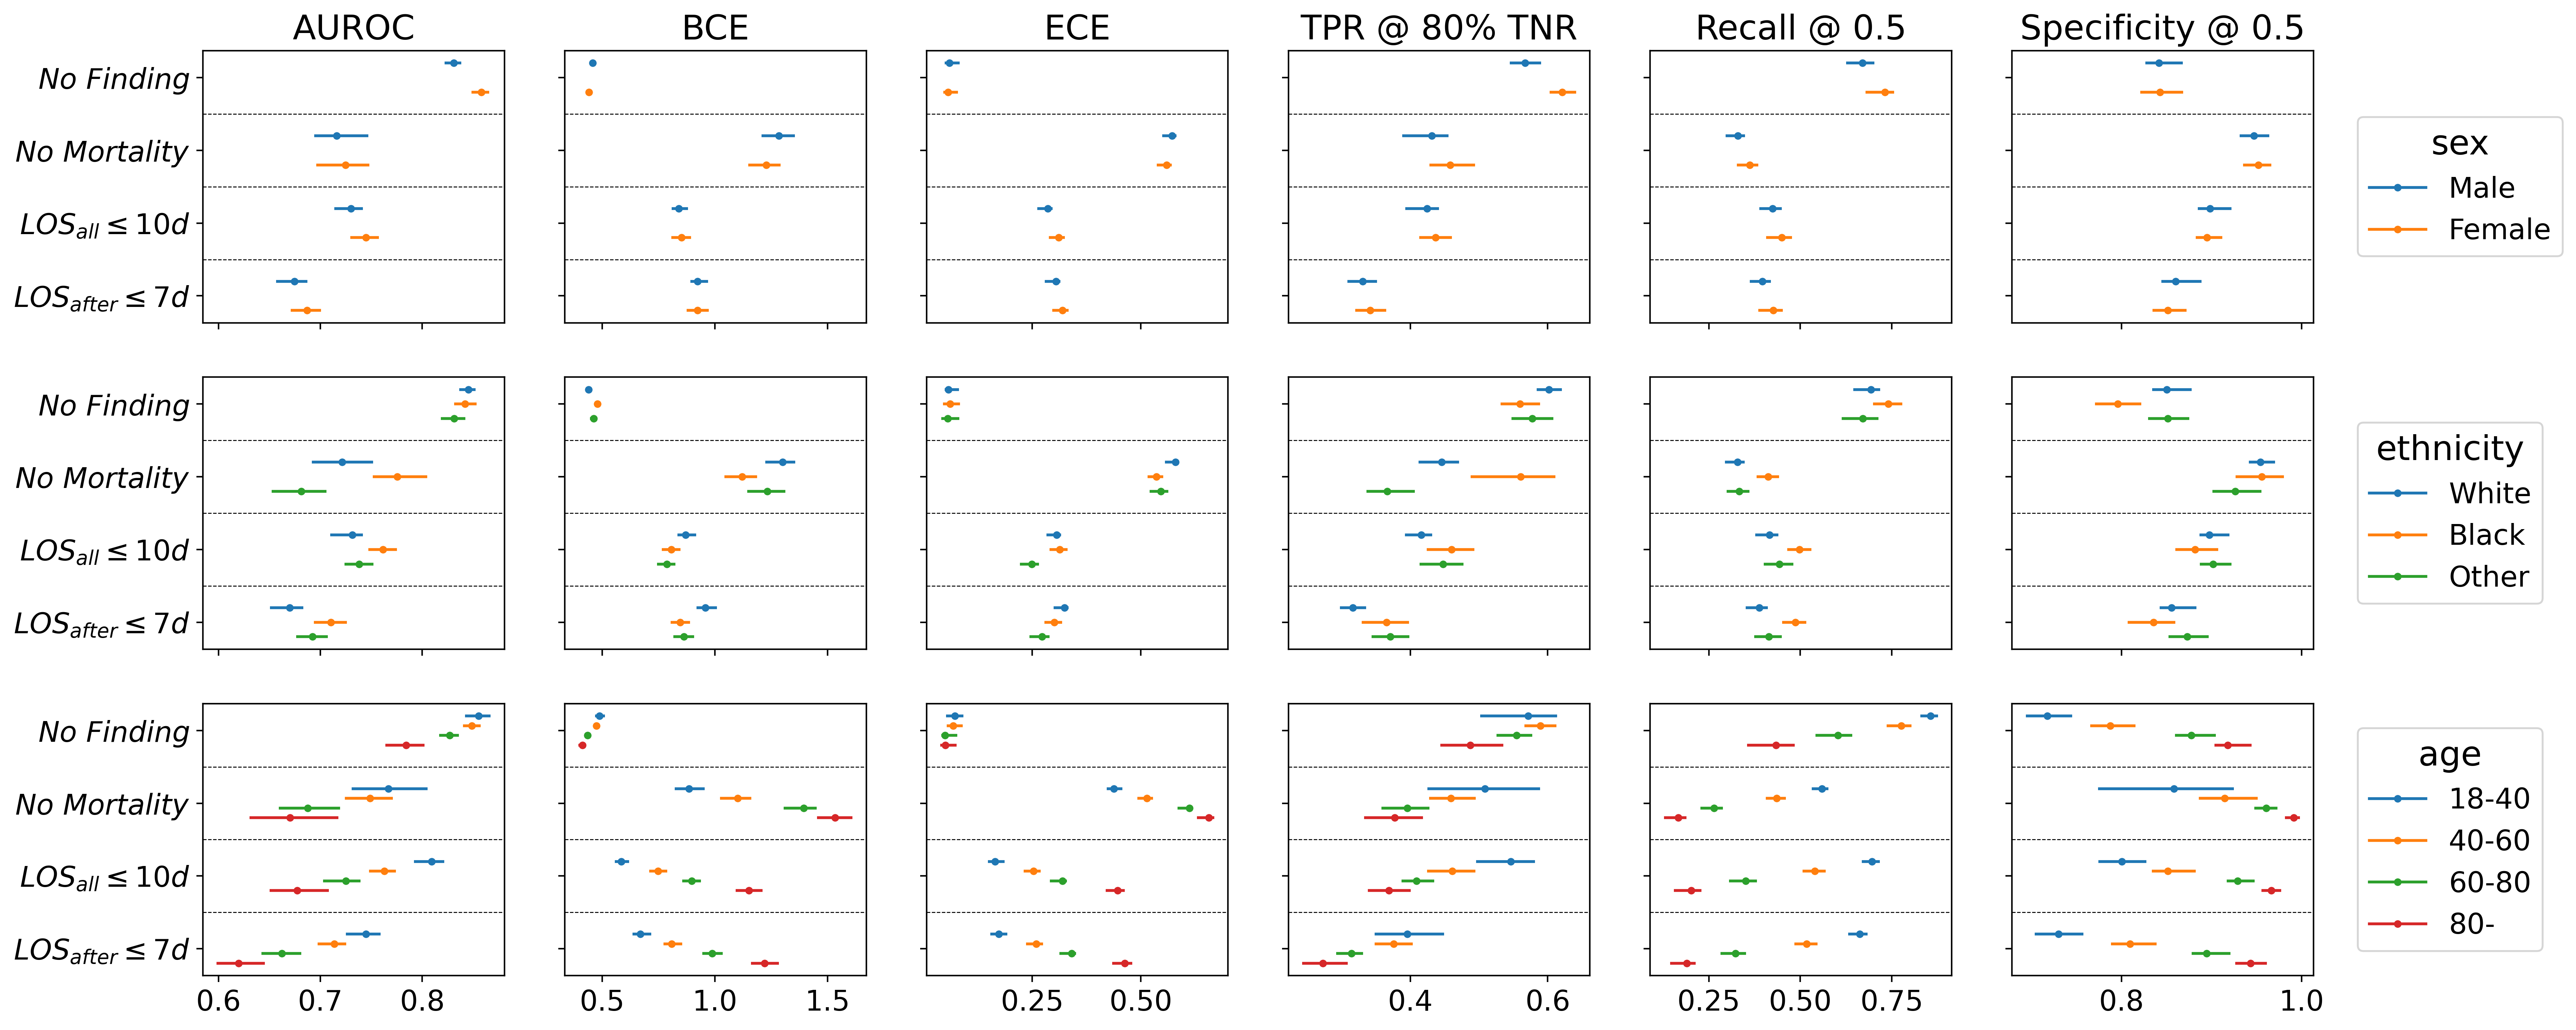

In [23]:
plt.rcParams['font.size'] = '15'
colors = ['C0', 'C1', 'C2', 'C3', 'C4']

attributes = ['sex', 'ethnicity', 'age']
metrics = ['AUROC', 
         'BCE',
        'ECE', 
        'TPR @ 80% TNR',
       'Recall @ 0.5',
       'Specificity @ 0.5',                                 
       ]

fig, axs = plt.subplots(ncols = len(metrics), nrows = len(attributes), figsize = (20, 3*len(attributes)), sharex = 'col', dpi = 400)
    
for d, attr in enumerate(attributes):
    grps = list(orders[attr])
#     grp_mapping = {
#         i: c for c, i in enumerate(grps)
#     }   
    target_mapping = {
        i: c for c, i in enumerate(reversed(targets))
    }    
    offsets = np.flip(np.linspace(-0.2, 0.2, len(grps)))
    for c, m in enumerate(metrics):     
        ax = axs[d][c]    
        subset = perf_df[(perf_df.metric == m) & (perf_df.eval_group == attr) & (perf_df[attr] != 'overall')]
        for e, grp in enumerate(grps):
            subset2 = subset[subset[attr] == grp]
            subset2['x'] = subset2['target'].map(target_mapping) + offsets[e]
            subset2 = subset2.sort_values(by = 'x', ascending = True)    
            subset2['lower_err'] = subset2['CI_med'] - subset2['CI_lower']
            subset2['upper_err'] = subset2['CI_upper'] - subset2['CI_med']
            yerrs = subset2[['lower_err', 'upper_err']].values.T
            ax.errorbar(y = subset2.x.values, x = subset2['CI_med'].values, fmt = '.', xerr = yerrs, color = colors[e]) 
        ax.set_yticks(range(len(targets)))
        if c == 0:
          #  ax.set_ylabel(attr)    
            ax.set_yticklabels(['$' + plot_mapping[tt] + '$' for tt in reversed(targets)])
        else:
            ax.set_yticklabels([])    
            
        if d == 0:
            ax.set_title(m)
            
        ax.axhline(0.5, linestyle='--', color='k', linewidth = 0.5)
        ax.axhline(1.5, linestyle='--', color='k', linewidth = 0.5)
        ax.axhline(2.5, linestyle='--', color='k', linewidth = 0.5)
            
    legend = [
        mlines.Line2D([], [], linestyle = '-', color = colors[c], marker ='.',
                     label = grp_name_mapping[grp]) for c, grp in list(zip(range(len(grps)), grps))
    ]

    # fig.subplots_adjust(right=0.9)
    leg1 = axs[d][-1].legend(handles = legend, loc='center left', bbox_to_anchor=(1.1, 0.5))  
    leg1.set_title(attr, prop = {'size': 'large'})
        
fig.savefig('./cxr_debias_figures/proxy_labels_performance.pdf', dpi = 400, bbox_inches = 'tight')